## Sentiment Analysis
https://www.analyticsvidhya.com/blog/2018/02/the-different-methods-deal-text-data-predictive-python/

In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer as sid
from textblob import TextBlob
from sentistrength import PySentiStr
from wordcloud import WordCloud

plot_size = plt.rcParams["figure.figsize"]  

plot_size[0] = 15  
plot_size[1] = 8  
plt.rcParams["figure.figsize"] = plot_size  

In [2]:
na_values = ['nan', 'N/A', 'NaN', 'NaT', '0']
ira_data = pd.read_csv('../Data/data_IRA_Ads.csv', sep=";", parse_dates=['AD_CREATION_DATE', 'AD_END_DATE'], 
                       dayfirst=False, index_col='AD_ID', na_values=na_values)

In [3]:
ira_data.head(100)

,AD_CLICKS,AD_CREATION_DATE,AD_END_DATE,AD_IMPRESSIONS,AD_LANDING_PAGE,AD_PATH,AD_SPEND,AD_TARGETING_AGE,AD_TARGETING_CUSTOM_AUDIENCE,AD_TARGETING_EXCLUDE,...,AD_TARGETING_GENDER,AD_TARGETING_INTERESTS,AD_TARGETING_LANGUAGE,AD_TARGETING_LOCATION,AD_TARGETING_LOCATION_LIVING_IN,AD_TARGETING_LOCATION_RECENTLY_IN,AD_TARGETING_PEOPLE_WHO_MATCH,AD_TARGETING_PLACEMENTS,AD_TEXT,AD_POTENTIAL_TARGET
AD_ID,,,,,,,,,,,,,,,,,,,,,
1,6.0,2015-10-25 06:28:33,2015-10-27 23:59:00,358.0,https://www.instagram.com/us_daily/,2015-q4/2015-10/P(1)0001736.pdf,161.23 RUB,18 - 51,NaN,NaN,...,NaN,"News broadcasting, Political party, Breaking n...",English (US),NaN,United States,NaN,NaN,Instagram Feed,Instgogogo,52000000.0
2,38.0,2015-10-20 10:36:20,2015-10-26 08:00:00,17256.0,https://www.instagram.com/south_lone_star/,2015-q4/2015-10/P(1)0001738.pdf,1000.00 RUB,18 - 65+,NaN,NaN,...,NaN,NaN,NaN,NaN,United States: Texas,NaN,NaN,Instagram Feed,You can go to hell or follow @south_lone_star ...,115000000.0
3,NaN,2015-10-26 10:45:51,2015-10-27 21:00:59,NaN,https://www.instagram.com/blackunionus/,2015-q4/2015-10/P(1)0001740.pdf,NaN,18 - 65+,NaN,NaN,...,NaN,Cop Block or Black (Color),English (US),NaN,United States,NaN,NaN,Instagram Feed,Black lives matter because we see what's going...,17000000.0
4,33.0,2016-04-19 07:49:45,NaT,14311.0,https://www.facebook.com/blacklivessss-9301580...,2016-q2/2016-04/P(1)0001742.pdf,7575.66 RUB,13 - 44,NaN,NaN,...,NaN,Cop Block,English (US),United States,NaN,NaN,NaN,Instagram Feed,Don't Shoot is a community site where you can ...,490000.0
5,201.0,2016-06-15 03:39:52,NaT,29786.0,https://www.facebook.com/govspending-165176135...,2016-q2/2016-06/P(1)0000001.pdf,3714.15 RUB,18 - 65+,NaN,NaN,...,NaN,Understanding racial segregation in the united...,NaN,NaN,United States: Georgia,NaN,NaN,Instagram Feed,WHERE is your VOICE?,NaN
6,NaN,2016-05-12 04:06:17,NaT,NaN,https://www.facebook.com/bat-240131319678646/,2016-q2/2016-05/P(1)0001744.pdf,NaN,13 - 44,NaN,NaN,...,NaN,"Christ's Commission Fellowship, Jesus, Jesus D...",English (US),United States,NaN,NaN,NaN,Instagram Feed,Conservative Christians. Pro-life/ gun/ police...,21000000.0
7,54.0,2016-05-13 01:18:08,NaT,23408.0,https://www.facebook.com/bat-240131319678646/,2016-q2/2016-05/P(1)0001746.pdf,2868.56 RUB,13 - 44,NaN,NaN,...,NaN,"Christ's Commission Fellowship, Jesus, Jesus D...",English (US),United States,NaN,NaN,NaN,Instagram Feed,Conservative Christians. Pro-life/ gun/ police...,21000000.0
8,43.0,2016-03-11 05:04:42,NaT,9559.0,https://www.instagram.com/black—america—today/,2016-q1/2016-03/P(1)0006379.pdf,2003.01 RUB,13 - 35,NaN,NaN,...,NaN,Hoodies or Trayvon Martin,English (UK)or English (US),United States,NaN,NaN,NaN,Instagram Feed,Trayvon Martin's lawyers wearing hoodies. Wear...,18000.0
9,13.0,2015-11-24 05:34:21,NaT,4871.0,https://www.instagram.com/veterans_us/,2015-q4/2015-11/P(1)0001229.pdf,1052.89 RUB,18 - 65+,NaN,NaN,...,NaN,"Veterans Day, American Revolutionary War or Pa...",English (US),United States,NaN,NaN,NaN,Instagram Feed,Edward was a combat engineer in Afghanistan wh...,3600000.0


### Extract Hashtags
Extracting the Hashtags in case they are needed later

In [4]:
# function to collect hashtags
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", str(i))
        hashtags.append(ht)

    return hashtags

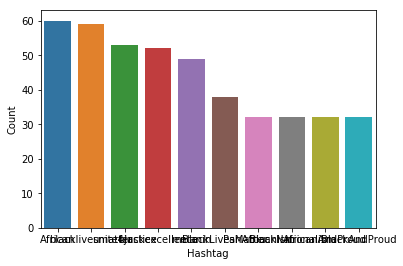

In [5]:
HT = hashtag_extract(ira_data['AD_TEXT'])
HT = sum(HT,[])

a = nltk.FreqDist(HT)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
#d.plot.bar()
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

### Removal of stopwords

In [6]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
ira_data['AD_TEXT'].apply(lambda x: " ".join(x for x in str(x).split() if x not in stop))

AD_ID
1                                              Instgogogo
2       You go hell follow @south_lone_star instead! T...
3       Black lives matter see what's going on. We car...
4       Don't Shoot community site find recent videos ...
5                                            WHERE VOICE?
6       Conservative Christians. Pro-life/ gun/ police...
7       Conservative Christians. Pro-life/ gun/ police...
8       Trayvon Martin's lawyers wearing hoodies. Wear...
9       Edward combat engineer Afghanistan whose job c...
10      Unbelievable amount US government's waste. Joi...
11      Veterans Day coming! There many ways show supp...
12      It's time us understand deserve best. It's tim...
13      The original Statue Liberty France black. The ...
14      This military campaign ambiguous given cost ne...
15      And would choose u president: create 11200 mil...
16      A Wounded Warrior service dog. Support Veteran...
17      What know PTSD? There greater agony. PTSD affe...
18      

### Add column with word count

In [7]:
ira_data['WORD_COUNT'] = ira_data['AD_TEXT'].apply(lambda x: len(str(x).split(" ")))
ira_data = ira_data[ira_data['WORD_COUNT'] > 5]

### Removal of words with less than 4 characters

In [8]:
ira_data['AD_TEXT'] = ira_data['AD_TEXT'].apply(lambda x: ' '.join([w for w in str(x).split() if len(w)>3]))

### Lemmatization
converts the word into its root word

In [9]:
from textblob import Word
ira_data['AD_TEXT'].apply(lambda x: " ".join([Word(word).lemmatize() for word in str(x).split()]))

AD_ID
2       hell follow @south_lone_star instead! Texas wh...
3       Black life matter because what's going care, w...
4       Don't Shoot community site where find recent v...
6       Conservative Christians. Pro-life/ gun/ police...
7       Conservative Christians. Pro-life/ gun/ police...
8       Trayvon Martin's lawyer wearing hoodies. Weari...
9       Edward combat engineer Afghanistan whose clear...
10      Unbelievable amount government's waste. Join l...
11      Veterans coming! There many way show your supp...
12      It's time understand that deserve best. It's t...
13      original Statue Liberty France black. Statue L...
14      This military campaign very ambiguous given th...
15      what would choose were president: create 11200...
16      Wounded Warrior service dog. Support Veterans ...
17      What know about PTSD? There greater agony. PTS...
18      What know about PTSD? There greater agony. PTS...
19      will save children? Click Learn more! Spending...
20      

### Lowercase

In [10]:
ira_data['AD_CLEANED_TEXT']=ira_data['AD_TEXT'].str.replace('[^\w\s]','')
ira_data['AD_CLEANED_TEXT']=ira_data['AD_TEXT'].str.replace("[^a-zA-Z#]", " ")

In [11]:
ira_data['AD_CLEANED_TEXT'] = ira_data['AD_CLEANED_TEXT'].apply(lambda x: " ".join(x.lower() for x in str(x).split()))

### Common word removal
Removes the 10 most common words

In [12]:
# freq = pd.Series(' '.join(ira_data['AD_CLEANED_TEXT']).split()).value_counts()[:10]
# freq = list(freq.index)
# ira_data['AD_CLEANED_TEXT']=ira_data['AD_CLEANED_TEXT'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))

### Rare words removal
Removes the 10 most uncommon words

In [13]:
# freq = pd.Series(' '.join(ira_data['AD_CLEANED_TEXT']).split()).value_counts()[-10:]
# freq = list(freq.index)
# ira_data['AD_CLEANED_TEXT']=ira_data['AD_CLEANED_TEXT'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))

In [14]:
# ira_data['AD_CLEANED_TEXT']=ira_data['AD_CLEANED_TEXT'].apply(lambda x: str(x).split())

### Spelling correction
check for ur etc. before correction

In [15]:
# ira_data['AD_CLEANED_TEXT'].apply(lambda x: str(TextBlob(x).correct()))

## Sentiment Analysis with TextBlob

In [16]:
ira_data['AD_TextBlob_POLARITY']=ira_data['AD_CLEANED_TEXT'].apply(lambda x: TextBlob(x).sentiment[0] )
ira_data['AD_TextBlob_SUBJECTIVITY']=ira_data['AD_CLEANED_TEXT'].apply(lambda x: TextBlob(x).sentiment[1] )

In [17]:
ira_data['AD_TextBlob_Sentiment'] = ira_data['AD_TextBlob_POLARITY'].apply(lambda x: 'positive' if x>0 else ('neutral' if x == 0 else 'negative'))

In [18]:
ira_data.head()

,AD_CLICKS,AD_CREATION_DATE,AD_END_DATE,AD_IMPRESSIONS,AD_LANDING_PAGE,AD_PATH,AD_SPEND,AD_TARGETING_AGE,AD_TARGETING_CUSTOM_AUDIENCE,AD_TARGETING_EXCLUDE,...,AD_TARGETING_LOCATION_RECENTLY_IN,AD_TARGETING_PEOPLE_WHO_MATCH,AD_TARGETING_PLACEMENTS,AD_TEXT,AD_POTENTIAL_TARGET,WORD_COUNT,AD_CLEANED_TEXT,AD_TextBlob_POLARITY,AD_TextBlob_SUBJECTIVITY,AD_TextBlob_Sentiment
AD_ID,,,,,,,,,,,,,,,,,,,,,
2,38.0,2015-10-20 10:36:20,2015-10-26 08:00:00,17256.0,https://www.instagram.com/south_lone_star/,2015-q4/2015-10/P(1)0001738.pdf,1000.00 RUB,18 - 65+,NaN,NaN,...,NaN,NaN,Instagram Feed,hell follow @south_lone_star instead! Texas wh...,115000000.0,37,hell follow south lone star instead texas wher...,0.000000,0.000000,neutral
3,NaN,2015-10-26 10:45:51,2015-10-27 21:00:59,NaN,https://www.instagram.com/blackunionus/,2015-q4/2015-10/P(1)0001740.pdf,NaN,18 - 65+,NaN,NaN,...,NaN,NaN,Instagram Feed,"Black lives matter because what's going care, ...",17000000.0,43,black lives matter because what s going care w...,-0.166667,0.433333,negative
4,33.0,2016-04-19 07:49:45,NaT,14311.0,https://www.facebook.com/blacklivessss-9301580...,2016-q2/2016-04/P(1)0001742.pdf,7575.66 RUB,13 - 44,NaN,NaN,...,NaN,NaN,Instagram Feed,Don't Shoot community site where find recent v...,490000.0,38,don t shoot community site where find recent v...,-0.010000,0.456667,negative
6,NaN,2016-05-12 04:06:17,NaT,NaN,https://www.facebook.com/bat-240131319678646/,2016-q2/2016-05/P(1)0001744.pdf,NaN,13 - 44,NaN,NaN,...,NaN,NaN,Instagram Feed,Conservative Christians. Pro-life/ gun/ police...,21000000.0,7,conservative christians pro life gun police mi...,-0.100000,0.100000,negative
7,54.0,2016-05-13 01:18:08,NaT,23408.0,https://www.facebook.com/bat-240131319678646/,2016-q2/2016-05/P(1)0001746.pdf,2868.56 RUB,13 - 44,NaN,NaN,...,NaN,NaN,Instagram Feed,Conservative Christians. Pro-life/ gun/ police...,21000000.0,7,conservative christians pro life gun police mi...,-0.100000,0.100000,negative


Text(0.5, 1.0, 'Histogram of sentiment on IRA Facebook Ads using TextBlob')

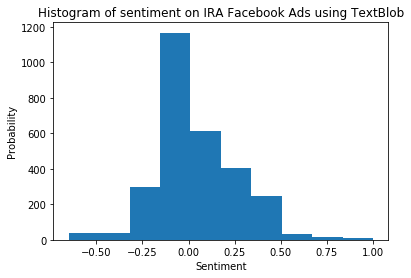

In [19]:
polarity=ira_data[ira_data['AD_TextBlob_SUBJECTIVITY'] < 0.8]
plt.hist(polarity['AD_TextBlob_POLARITY'], histtype='bar')
plt.xlabel('Sentiment')
plt.ylabel('Probability')
plt.title('Histogram of sentiment on IRA Facebook Ads using TextBlob')

Text(0.5, 1.0, 'Histogram of subjectivity on IRA Facebook Ads')

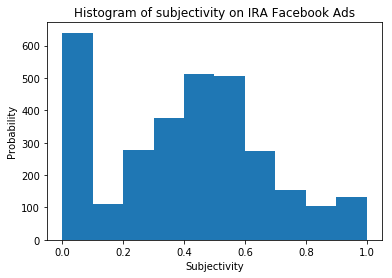

In [20]:
plt.hist(ira_data['AD_TextBlob_SUBJECTIVITY'])
plt.xlabel('Subjectivity')
plt.ylabel('Probability')
plt.title('Histogram of subjectivity on IRA Facebook Ads')

## Sentiment Analysis with VADER

In [21]:
analyzer = sid()
ira_data['AD_VADER_POLARITY']=ira_data['AD_TEXT'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
ira_data['AD_VADER_Sentiment'] = ira_data['AD_VADER_POLARITY'].apply(lambda x: 'positive' if x>=0.5 else ('negative' if x <= -0.5 else 'negative'))
ira_data['AD_VADER_Sentiment'].value_counts()

negative    1962
positive    1129
Name: AD_VADER_Sentiment, dtype: int64

Text(0.5, 1.0, 'Histogram of sentiment on IRA Facebook Ads using VADER')

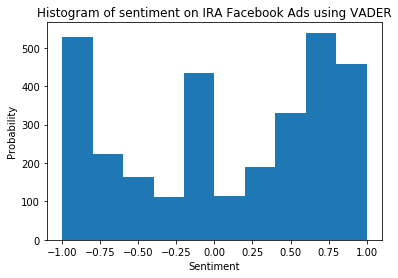

In [22]:
plt.hist(ira_data['AD_VADER_POLARITY'], histtype='bar')
plt.xlabel('Sentiment')
plt.ylabel('Probability')
plt.title('Histogram of sentiment on IRA Facebook Ads using VADER')

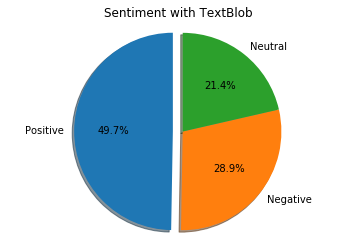

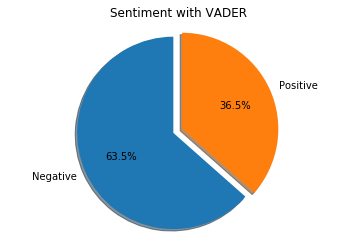

In [23]:
fig1, ax1 = plt.subplots()
explode = (0.1, 0, 0)
labels='Positive', 'Negative', 'Neutral'
ax1.pie(ira_data['AD_TextBlob_Sentiment'].value_counts(), labels=labels, explode=explode, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.title('Sentiment with TextBlob')

labels2 = 'Negative', 'Positive'
fig2, ax2 = plt.subplots()
ax2.pie(ira_data['AD_VADER_Sentiment'].value_counts(), explode=(0.1, 0), labels=labels2, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax2.axis('equal') 
plt.title('Sentiment with VADER')

plt.show()

* * * * * * * * * *


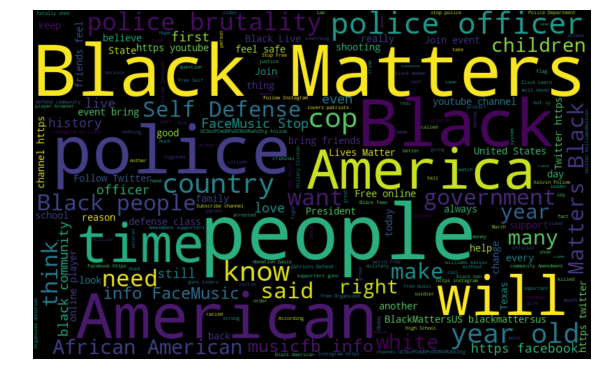

In [24]:
all_words = ' '.join([text for text in ira_data['AD_TEXT']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

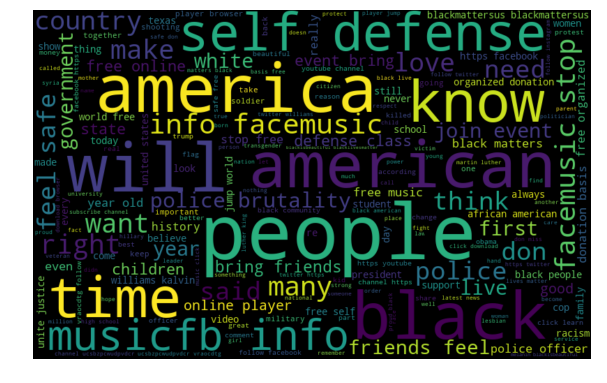

In [25]:
pos_words = ' '.join([text for text in ira_data['AD_CLEANED_TEXT'][ira_data['AD_TextBlob_POLARITY'] > 0]])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(pos_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

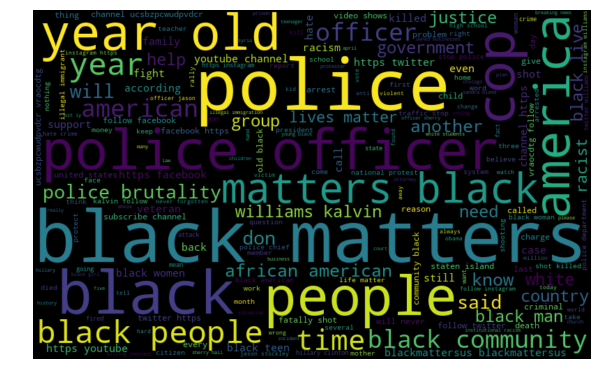

In [26]:
neg_words = ' '.join([text for text in ira_data['AD_CLEANED_TEXT'][ira_data['AD_TextBlob_POLARITY'] < 0]])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(neg_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [27]:
ira_data = ira_data[ira_data['AD_TextBlob_Sentiment']==ira_data['AD_VADER_Sentiment']]

In [28]:
ira_data.head()

,AD_CLICKS,AD_CREATION_DATE,AD_END_DATE,AD_IMPRESSIONS,AD_LANDING_PAGE,AD_PATH,AD_SPEND,AD_TARGETING_AGE,AD_TARGETING_CUSTOM_AUDIENCE,AD_TARGETING_EXCLUDE,...,AD_TARGETING_PLACEMENTS,AD_TEXT,AD_POTENTIAL_TARGET,WORD_COUNT,AD_CLEANED_TEXT,AD_TextBlob_POLARITY,AD_TextBlob_SUBJECTIVITY,AD_TextBlob_Sentiment,AD_VADER_POLARITY,AD_VADER_Sentiment
AD_ID,,,,,,,,,,,,,,,,,,,,,
6,NaN,2016-05-12 04:06:17,NaT,NaN,https://www.facebook.com/bat-240131319678646/,2016-q2/2016-05/P(1)0001744.pdf,NaN,13 - 44,NaN,NaN,...,Instagram Feed,Conservative Christians. Pro-life/ gun/ police...,21000000.0,7,conservative christians pro life gun police mi...,-0.100000,0.100000,negative,0.0000,negative
7,54.0,2016-05-13 01:18:08,NaT,23408.0,https://www.facebook.com/bat-240131319678646/,2016-q2/2016-05/P(1)0001746.pdf,2868.56 RUB,13 - 44,NaN,NaN,...,Instagram Feed,Conservative Christians. Pro-life/ gun/ police...,21000000.0,7,conservative christians pro life gun police mi...,-0.100000,0.100000,negative,0.0000,negative
8,43.0,2016-03-11 05:04:42,NaT,9559.0,https://www.instagram.com/black—america—today/,2016-q1/2016-03/P(1)0006379.pdf,2003.01 RUB,13 - 35,NaN,NaN,...,Instagram Feed,Trayvon Martin's lawyers wearing hoodies. Wear...,18000.0,19,trayvon martin s lawyers wearing hoodies weari...,-0.058333,0.479167,negative,0.4710,negative
9,13.0,2015-11-24 05:34:21,NaT,4871.0,https://www.instagram.com/veterans_us/,2015-q4/2015-11/P(1)0001229.pdf,1052.89 RUB,18 - 65+,NaN,NaN,...,Instagram Feed,Edward combat engineer Afghanistan whose clear...,3600000.0,31,edward combat engineer afghanistan whose clear...,0.300000,0.441667,positive,0.7777,positive
11,31.0,2015-11-10 06:19:02,2015-11-30 06:09:00,4802.0,https://www.instagram.com/veterans—us/,2015-q4/2015-11/P(1)0001749.pdf,1960.34 RUB,18 - 65+,NaN,NaN,...,Instagram Feed,Veterans coming! There many ways show your sup...,770000.0,55,veterans coming there many ways show your supp...,0.300000,0.500000,positive,0.9151,positive
